This notebook considers the t test both for a simulated matrix estimate and a simulated graph model.

In [1]:
include("definitions_test_statistics.jl")
using Distributions, Statistics, LinearAlgebra, StatsPlots, Plots, Graphs, GraphRecipes
mu = [ 0; 0 ]
M2 = [1 -3; -1 1];
cov = [ 1 2 ; 2 3];
c = cov * cov / 100;
#c = I(2);
d = MvNormal(mu,c);
mc_reps = 3000;
sample_size = 500;
p = 2;
q = 1;
r = p-q;
#first dimension of errors is mc_reps and second dimension is sample
errors = [M2 + rand(d,p) for _ in 1:mc_reps, _ in 1:sample_size];
#makes a mc_reps by 1 matrix of matrices
matrix_estimates = mean(errors,dims=(2));
mapslices(eigvals,matrix_estimates,dims=())



demeaned_matrices = [errors[i,:,:] .- matrix_estimates[i,:,:] for i in 1:mc_reps]

cov_estimates = Array{Float64,3}(undef,mc_reps,p^2,p^2) 
smaller_cov_estimate = Array{Float64}(undef,p,p);
smaller_cov_estimates = Array{Float64,3}(undef,mc_reps,p,p)

for mcrep in 1:mc_reps
    cov_estimate = Array{Float64,2}(undef,p^2,p^2);
    fill!(cov_estimate,0.0);
    for s in 1:sample_size
        cov_estimate += vec(demeaned_matrices[mcrep][s])*vec(demeaned_matrices[mcrep][s])';
    end
    #average across other dimension
    fill!(smaller_cov_estimate,0.0)
    for maus in 1:p
        #1 p+1 2p+1 to p 2p 
        smaller_cov_estimate += cov_estimate[(1+ (maus-1)*p) : (maus*p) , (1+ (maus-1)*p) : (maus*p) ]
    end

    cov_estimates[mcrep,:,:] = cov_estimate / sample_size;
    smaller_cov_estimates[mcrep,:,:] = smaller_cov_estimate / (p*sample_size)
end


Test the constituent functions.

In [2]:
reference = [randn() for _ in 1:mc_reps];
point_estimator = [Dhat(matrix_estimates[i],q,1,1) for i in 1:mc_reps];
t_statistic = [tStat(matrix_estimates[i],M2,smaller_cov_estimates[i,:,:],q,1,1,sample_size) for i in 1:mc_reps];
t_statistic = dropdims(stack(t_statistic,dims=1),dims=2); #stacks rows on top of one another

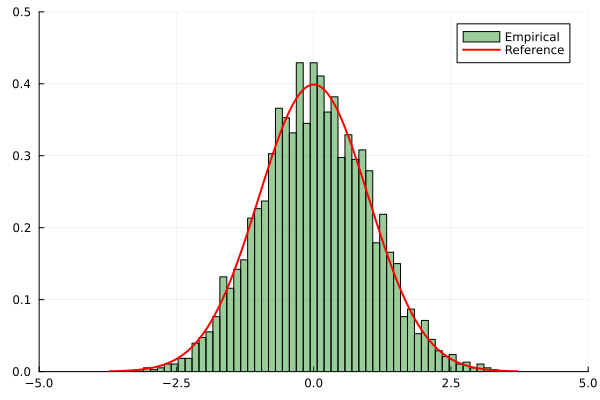

In [3]:
dens(x) = 1/sqrt(2pi) * exp(-x^2/2)
b_range = range(-5, 5, length=80)

histogram(real(t_statistic[:,1]), label="Empirical", bins=b_range, normalize=:pdf, color=:green,fillalpha=0.4)
plot!(Normal(0,1), label="Reference", lw=2, color=:red)
xlims!(-5, 5)
ylims!(0, .5)


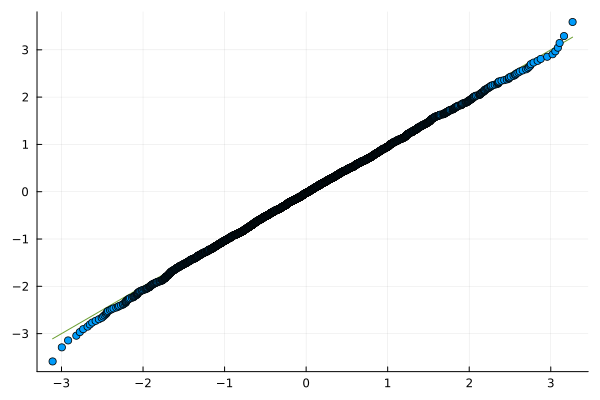

In [7]:
qqplot(real(t_statistic[:,1]),Normal(0,1))

In [8]:
#savefig("qqt_better.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/qqt_better.svg"

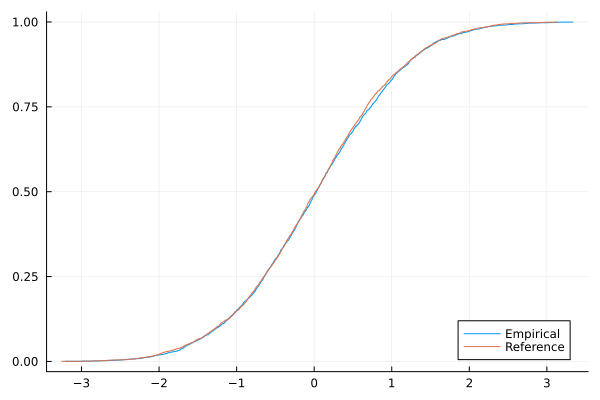

In [9]:
using StatsBase
scatter(ecdf(real(t_statistic[:,1])),label="Empirical")
scatter!(ecdf(reference),label="Reference",legend=:bottomright)

In [10]:
#savefig("cdft_better.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/cdft_better.svg"

Simulate t-statistic from graph model

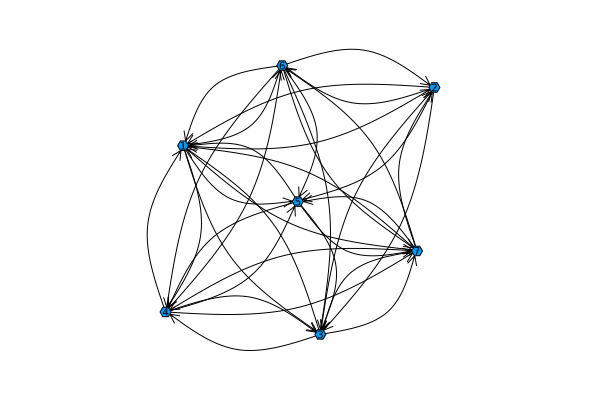

In [4]:
p = 7
connections = 35
mc_reps = 4000;
sample_size = 3000;
g = SimpleDiGraph(p,connections);
pl = graphplot(adjacency_matrix(g), names=1:connections, curvature_scalar=0.1)
#ev,R = eigen(Matrix(adjacency_matrix(g)),sortby = x -> (-floor(real(x), digits = 6), floor(imag(x), digits = 6)))

In [21]:
#savefig(pl,"graph_plot.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/graph_plot.svg"

In [5]:
using CSV
#CSV.write("graph_data.csv",DataFrame(Matrix(adjacency_matrix(g)),:auto))
#CSV.File("graph_data.csv") |> Tables.matrix

In [6]:
w = SimulateGraphtStat(mc_reps,sample_size,g,1,3);

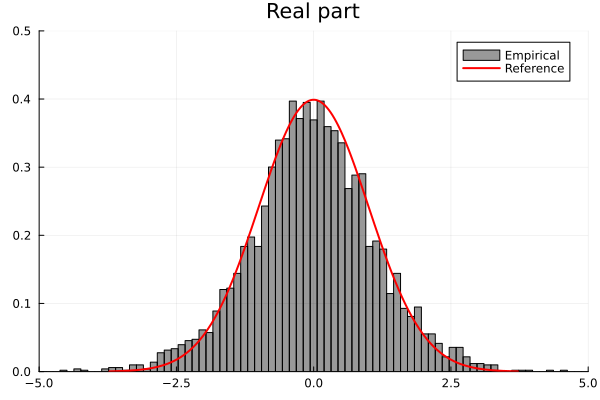

In [12]:
dens(x) = 1/sqrt(2pi) * exp(-x^2/2)
b_range = range(-5, 5, length=80)

histogram(real(w[:,1]), label="Empirical", bins=b_range, normalize=:pdf, color=:black,fillalpha=0.4)
plot!(Normal(0,1), label="Reference", lw=2, color=:red,title="Real part")
xlims!(-5, 5)
ylims!(0, .5)


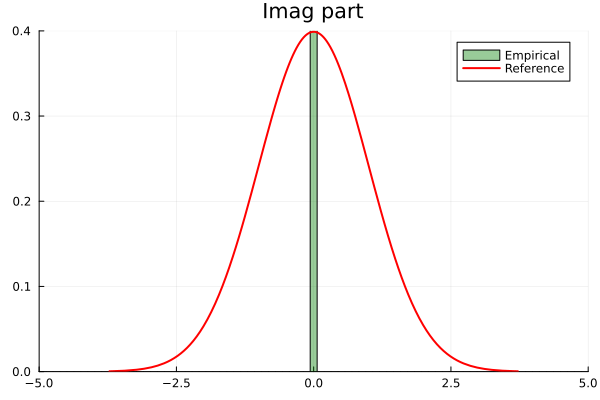

In [13]:
dens(x) = 1/sqrt(2pi) * exp(-x^2/2)
b_range = range(-5, 5, length=80)

histogram(imag(w[:,1]), label="Empirical", bins=b_range, normalize=:pdf, color=:green,fillalpha=0.4)
plot!(Normal(0,1), label="Reference", lw=2, color=:red,title="Imag part")
xlims!(-5, 5)
ylims!(0, 0.4)


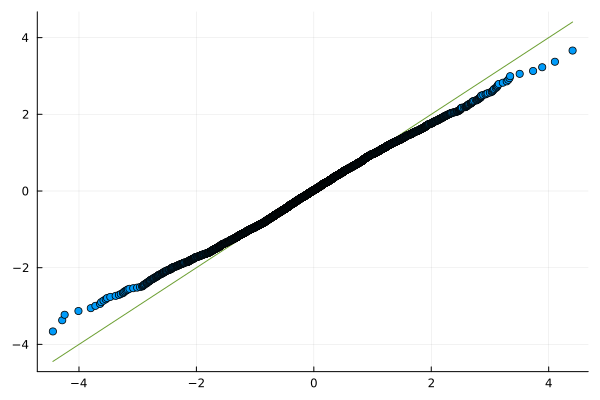

In [19]:
qq = qqplot(real(real(w[:,1])),Normal(0,1))

In [22]:
#savefig(qq,"qq_graph.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/qq_graph.svg"